# Time series analysis - Example code 12: Predicting a signal

**Lund University, Lund, Sweden**

**Reference:**  
"An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

**This is an IMPORTANT example!**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')



from tsa_lth.modelling import estimateARMA
from tsa_lth.analysis import acf, pzmap, naive_pred
from tsa_lth.tests import whiteness_test
from tsa_lth.tools.poly import polydiv

## Select parameters

In [2]:
k = 5  # Prediction horizon; try some different ones
N = 10000  # Begin with lots of samples - then try fewer
noLags = 50
extraN = 100

# Some examples of polynomials to test
C = np.array([1])
A = np.array([1, -1.96, 0.97])  # Strong periodicity; this is easy to predict

# Other examples to try:
# A = np.array([1, -0.8, 0.6])  # Weak periodicity; this is difficult to predict

# C = np.array([1, -2])  # Why is the prediction instable with this C polynomial?
# A = np.array([1, -1.96, 0.97])  # Strong periodicity

# C = np.array([1, -.2])
# A = np.convolve([1, -1], [1, -0.2])  # Signal with a slow trend

# C = np.array([1, -.2])
# A = np.convolve(np.concatenate([[1], np.zeros(12), [-1]]), [1, -0.7])  # Signal with a season

## Simulate some data and examine the location of the roots

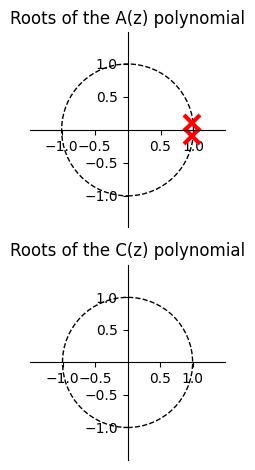

In [3]:
e = np.random.randn(N + extraN)
y = lfilter(C, A, e)
y = y[extraN:]

fig = plt.figure()
ax1 = fig.add_subplot(211)
pzmap([1], A, ax=ax1, show=False)
ax1.set_title('Roots of the A(z) polynomial')

ax2 = fig.add_subplot(212)
pzmap([1], C, ax=ax2, show=False)
ax2.set_title('Roots of the C(z) polynomial')

plt.tight_layout()
plt.show()

## Form the prediction polynomials

First, use the true parameters to test the theory.

In [4]:
F, G = polydiv(C, A, k)
print(f"F = {F}")
print(f"G = {G}")

F = [1.         1.96       2.8716     3.727136   4.51973456]
G = [ 0.          0.          0.          0.          0.          5.24335782
 -4.38414252]


## Estimate the parameters and use these instead. 
Also try: reducing N to see how this affects the parameter estimates and the
 predictions. You can use this approach to examine the quality you can
 expect of your predictions using your polynomials and data lengths.

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 1.9619(±0.0023)·z⁻¹ + 0.9719(±0.0023)·z⁻²

Polynomial orders: nA = 2
Number of free coefficients: 2
Fit to estimation data (NRMSE): 97.64%
FPE : 0.985  MSE : 0.984
AIC : 28217.955   BIC : 28232.375



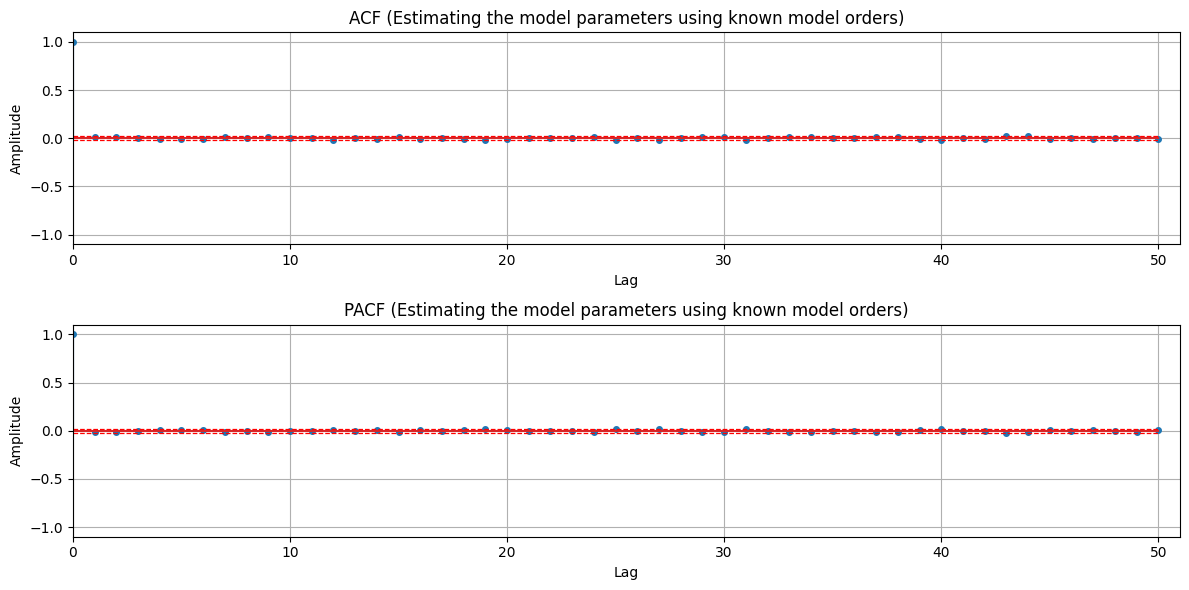

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 20.27 < 37.65)
  McLeod-Li test:        True (white if 18.62 < 37.65)
  Monti test:            True (white if 20.16 < 37.65)
  Sign change test:      True (white if 0.50 in [0.49,0.51])


In [5]:
foundModel = estimateARMA(y, A=A, C=C, titleStr='Estimating the model parameters using known model orders', noLags=noLags)
F, G = polydiv(foundModel.C, foundModel.A, k)

## Form the predicted data

In [6]:
yhatk = lfilter(G, C, y)

## Plot the predictions

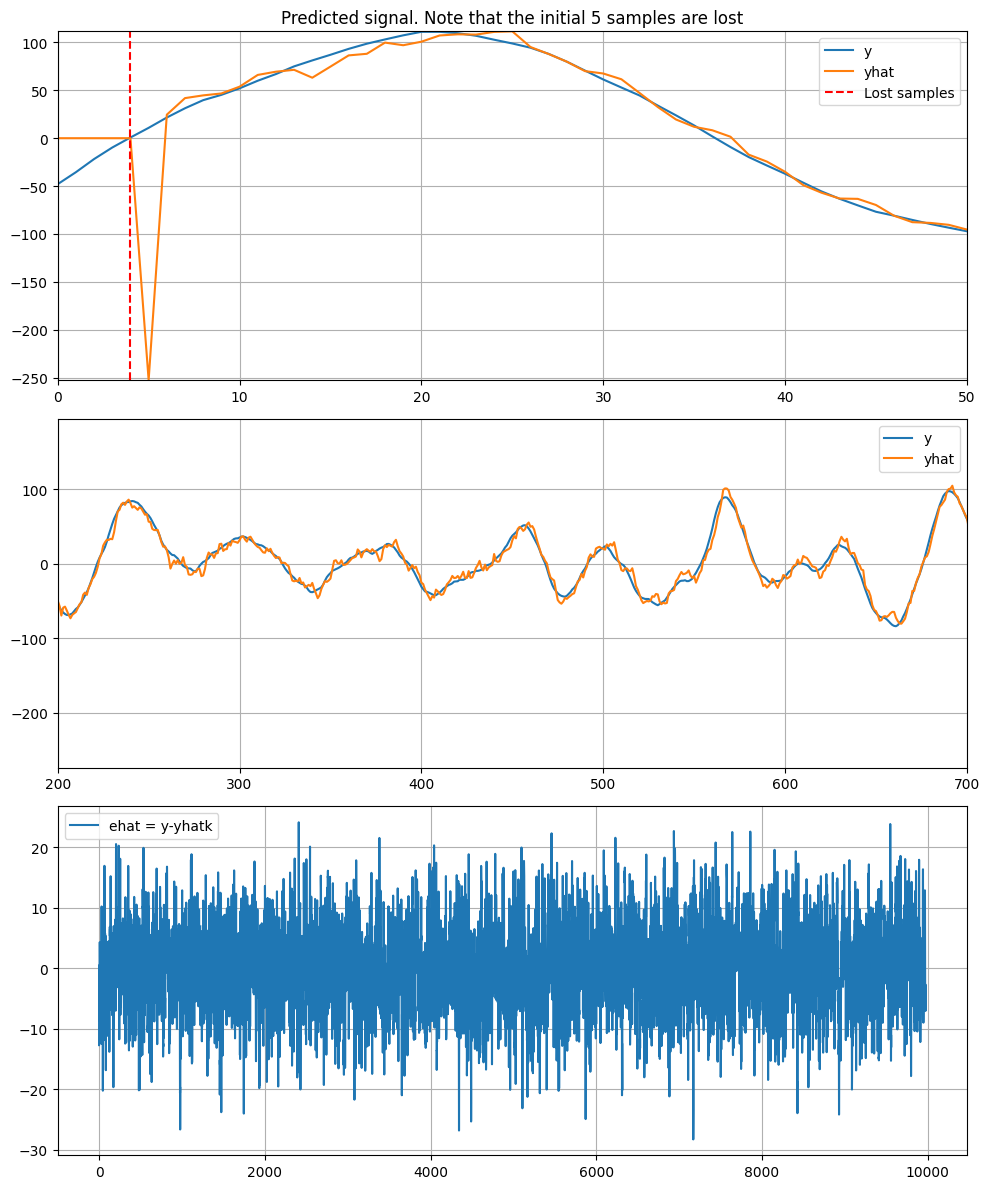

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Top plot - first 50 samples
maxInd = 40
m1 = min(np.min(yhatk[:maxInd]), np.min(y[:maxInd]))
m2 = max(np.max(yhatk[:maxInd]), np.max(y[:maxInd]))
ax1.plot(y, label='y')
ax1.plot(yhatk, label='yhat')
ax1.axvline(x=k-1, color='red', linestyle='--', label='Lost samples')
ax1.set_xlim([0, 50])
ax1.set_ylim([m1, m2])
ax1.legend()
ax1.set_title(f'Predicted signal. Note that the initial {k} samples are lost')
ax1.grid(True)

# Middle plot - samples 200-700
ax2.plot(y, label='y')
ax2.plot(yhatk, label='yhat')
ax2.set_xlim([200, 700])
ax2.legend()
ax2.grid(True)

# Bottom plot - prediction error
ehat = y - yhatk
ehat = ehat[k+20:]  # Remove the corrupted samples
ax3.plot(ehat, label='ehat = y-yhatk')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

## Check if prediction residual is white

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 8821.35 < 37.65)
  McLeod-Li test:        False (white if 4136.34 < 37.65)
  Monti test:            False (white if 6117.82 < 37.65)
  Sign change test:      False (white if 0.24 in [0.49,0.51])


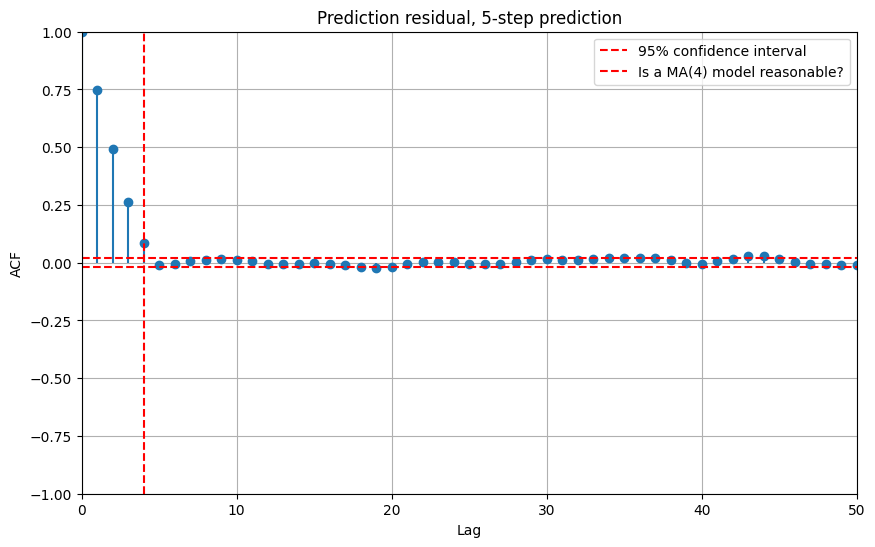

This is a 5-step prediction. Ideally, the residual should be an MA(4) process.


In [8]:
try:
    whiteness_test(ehat)
    
    # Plot ACF
    acfEst = acf(ehat, noLags)
    
    plt.figure(figsize=(10, 6))
    plt.stem(range(len(acfEst)), acfEst, basefmt=' ')
    
    # Confidence interval
    conf_int = 1.96 / np.sqrt(len(ehat))
    plt.axhline(y=conf_int, color='r', linestyle='--', label='95% confidence interval')
    plt.axhline(y=-conf_int, color='r', linestyle='--')
    
    # Mark k-1 lag
    plt.axvline(x=k-1, color='r', linestyle='--', label=f'Is a MA({k-1}) model reasonable?')
    
    plt.xlim([0, noLags])
    plt.ylim([-1, 1])
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.title(f'Prediction residual, {k}-step prediction')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    
    print(f'This is a {k}-step prediction. Ideally, the residual should be an MA({k-1}) process.')
except Exception as e:
    print(f"Error: {e}")

## Examine the variance of the prediction residual

In [9]:
var_y = np.var(y, ddof=0)
var_ehat = np.var(ehat, ddof=0)

print(f'Prediction the signal {k}-steps ahead.')
print(f'  The variance of original signal is         {var_y:5.2f}')
print(f'  The variance of the prediction residual is   {var_ehat:5.2f}')

if var_ehat < var_y:
    print(f'  Amount of signal that was predicted is       {(1 - var_ehat/var_y)*100:5.2f}%')
else:
    print('  **** BEWARE: the prediction is not accurate!!! ****')

Prediction the signal 5-steps ahead.
  The variance of original signal is         1770.94
  The variance of the prediction residual is   48.44
  Amount of signal that was predicted is       97.26%


## Compare with a naive predictor

If we assume no seasonality, the current sample might be a reasonable guess. This will cause a prediction that is delayed k steps.

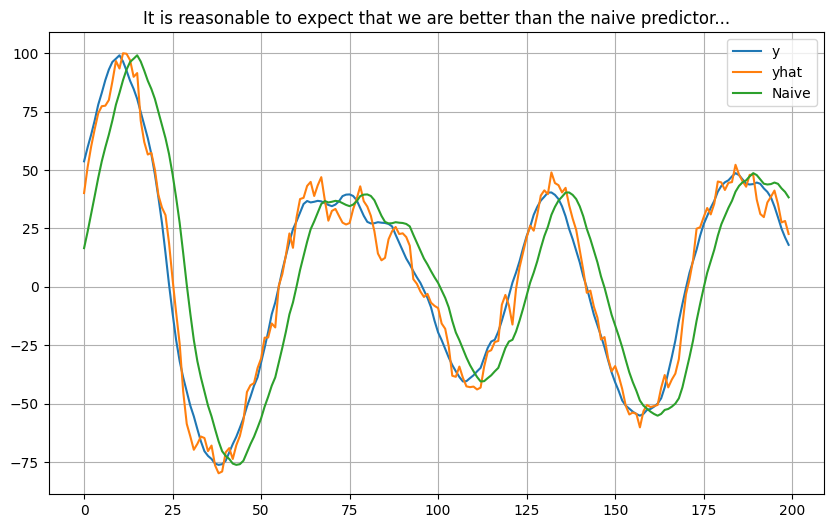

Naive predictor:
  The variance of the naive predictor is      482.98
  Amount predicted by the naive is             73.85%


In [10]:
testDataInd = np.arange(N-200, N)
yNaive, var_naive, ehatN = naive_pred(y, testDataInd, k)

plt.figure(figsize=(10, 6))
plt.plot(y[testDataInd], label='y')
plt.plot(yhatk[testDataInd], label='yhat')
plt.plot(yNaive, label='Naive')
plt.title('It is reasonable to expect that we are better than the naive predictor...')
plt.legend()
plt.grid(True)
plt.show()

print(f'Naive predictor:')
print(f'  The variance of the naive predictor is      {var_naive:5.2f}')
print(f'  Amount predicted by the naive is             {(1 - var_naive/np.var(y[testDataInd], ddof=0))*100:5.2f}%')